# g filter

**OBSERVATIONS**

g:  3x120s\
r:  3x120s\
i:  3x120s\
Ha: 1x900s + 4x300s\
Hb: 4x1200s

**TOBI**

- Sensor Type: CCD - KAF-16200 APS cut (35mm diagonal)
- Horizontal Resolution: 4499 pixels
- Vertical Resolution: 3599 pixels
- Pixel Size: 6 µm x 6 µm
- ADC: 16 bit
- Readout Noise: 9e- typical value
- Gain Factor: 0.6e-/ ADU
- Full Well: ~40,000e-
- Dark Current: >0.25 electrons/second at 0°C
- Maximum Exposure Length: Unlimited
- Minimum Exposure Length: 200 ms
- Cooling: Thermoelectric set point with max ΔT=>-50°C
- 6 µm pixel means 0.44”/pix

**IMAGE REDUCTION**

In real situations getting dark frames with same exposure times of object frames is impraticable. Lot of time wasted. We can repeat measures for different (short) exposure times and obtain a curve of the dark current counts vs time. 


$$\text{Final}= \left[ \text{Object Frame} - \left(\text{Dark} - \text{Bias}\right) \tfrac{\Delta t_\text{Obj}}{\Delta t_\text{Dark}} - \text{Bias} \right] {\huge/} \text{Flat normalized}$$ 

IF object frame exposure time and dark frame exposure time are equal, like in our case:

$$\text{Final}= \left[ \text{Object Frame} - \text{Dark} \right] {\huge/} \text{Flat normalized}$$ 

**Flat Frames:**

- Purpose: Flat frames correct for vignetting, dust spots, and optical imperfections in the imaging system (such as the lens or telescope).
- What they capture: Flat frames are taken by pointing the camera at a uniformly lit surface (e.g., a white sheet of paper, a clear blue sky, or a lightbox) with the same exposure time and settings as the light frames.
- Effect: These frames correct for variations in brightness across the image, such as areas where the image is darker (vignetting) or where dust spots on the lens or sensor create uneven lighting. The flat frames are used to divide the light frames to normalize the brightness.

Flats counts are much more than the object frame. This is not a deal, because in the end we have to normalize them.

In [1]:
# Open the FITS file
from astropy.io import fits
from pathlib import Path

base_dir = Path("data/data_g_filter_28_10_24")
file_names = [f"IC5146_g_{i:03d}.fit" for i in range(3)]  
file_paths = [str(base_dir / name) for name in file_names]

frame_obj = []
g_filter_header = []

for f_p in file_paths:
    
    with fits.open(f_p) as hdul:
        #hdul.info()
        g_filter_header.append(hdul[0].header)
        frame_obj.append(hdul[0].data)   

In [2]:
print(g_filter_header[0])


SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 4499                                                  NAXIS2  =                 3599                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-16200: fw rev 3.52'                                   FILTER  =           'Position 5'                                                EXPTIME =           120.000                                                     DATE-OBS=           '2024-10-28T17:35:02

In [3]:
# convert from ADU to electron/s

gain_factor = 0.6

for i in range(3):
    frame_obj[i] = frame_obj[i] * gain_factor

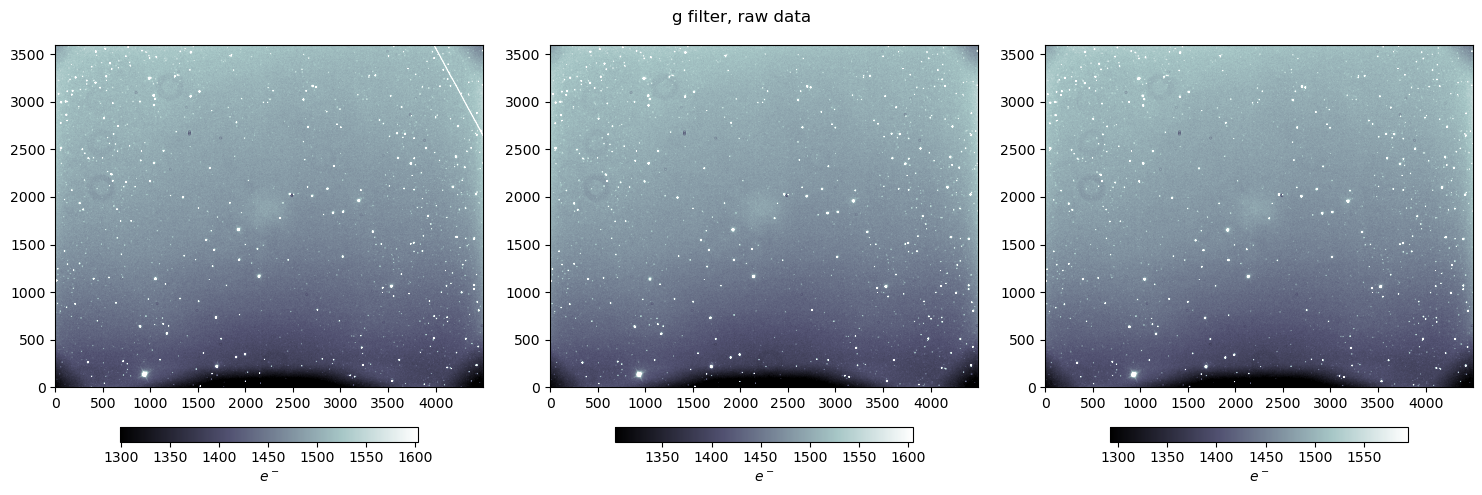

In [4]:
### === Object frames === ###

import numpy as np
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("g filter, raw data")

for i in range(3):
    
    im = ax[i].imshow(frame_obj[i], clim=np.quantile(frame_obj[i], [0.01, 0.99]), cmap='bone', origin='lower')  
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  

plt.tight_layout()
plt.show()


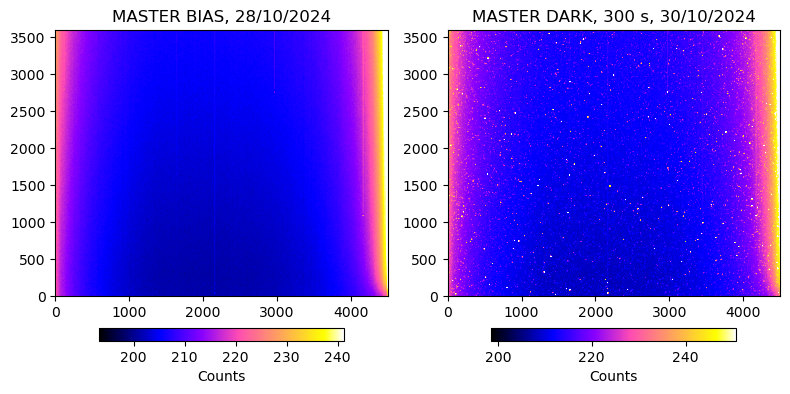

In [5]:
### === MASTER BIAS and DARK === ###

with fits.open('data/master_bias.fit') as hdul:
    master_bias = hdul[0].data 

with fits.open('data/master_dark_300.fit') as hdul:
    master_dark = hdul[0].data  

fig, ax = plt.subplots(1,2,figsize=(8,4))

im1 = ax[0].imshow(master_bias, clim=np.quantile(master_bias, [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im1, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar
ax[0].set_title("MASTER BIAS, 28/10/2024")

im2 = ax[1].imshow(master_dark, clim=np.quantile(master_dark, [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im2, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar
ax[1].set_title("MASTER DARK, 300 s, 30/10/2024")

plt.tight_layout()
plt.show()


SIMPLE  =                    T                                                  BITPIX  =                   16                                                  NAXIS   =                    2                                                  NAXIS1  =                 4499                                                  NAXIS2  =                 3599                                                  BZERO   =           32768.000000                                                BSCALE  =             1.000000                                                  DATAMIN =             0.000000                                                  DATAMAX =           65535.000000                                                INSTRUME=           'ATIK-16200: fw rev 3.52'                                   FILTER  =           'Position 5'                                                EXPTIME =           1.000                                                       DATE-OBS=           '2024-10-28T16:28:24

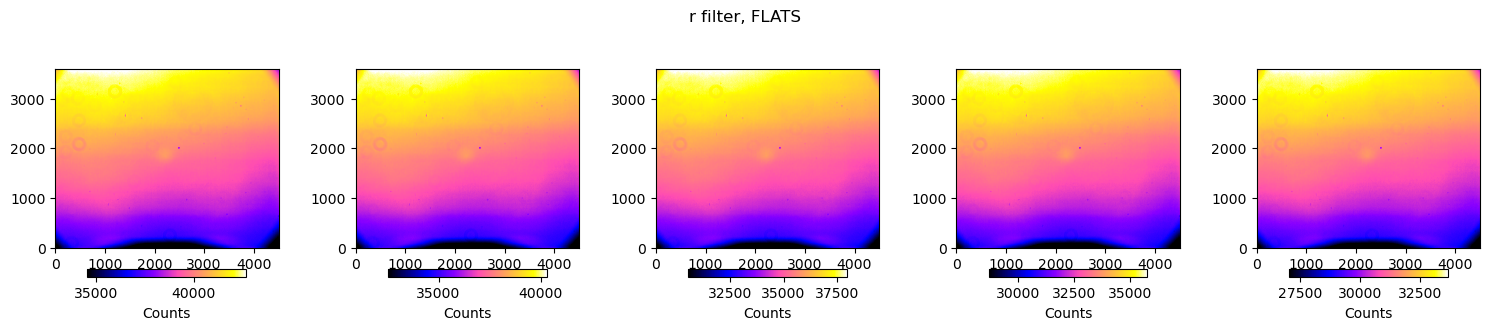

In [7]:
### === Flats === ###

file_path = [f'data/flat_g_28_10_24/Calib_0{str(i).zfill(1)}flat_m20_g_1s.fit' for i in range(40,45)]

flat = []

with fits.open(file_path[0]) as hdul:
    print(hdul[0].header)

for f_p in file_path:    
    with fits.open(f_p) as hdul:
        flat.append(hdul[0].data) 

fig, ax = plt.subplots(1,5,figsize=(15,3.5))
fig.suptitle("r filter, FLATS")

for i in range(5):

    im = ax[i].imshow(flat[i], clim=np.quantile(flat[i], [0.01, 0.99]), cmap='gnuplot2', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="Counts")  # Make sure to use the `im` object for colorbar

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [8]:
# normalize each flat to it's mean value

for i in range(len(flat)):
    mean = np.mean(flat[i]) 
    flat[i] = flat[i]/mean

# stack and take the mean as the master flat 

flat_stack = np.stack(flat, axis=0)  
flat_mean = np.mean(flat_stack, axis=0)   

del flat, flat_stack  

In [9]:
frame_sky = []

for i in range(3):
    frame_sky.append((frame_obj[i] - master_dark)/flat_mean)

del frame_obj, master_dark, master_bias 


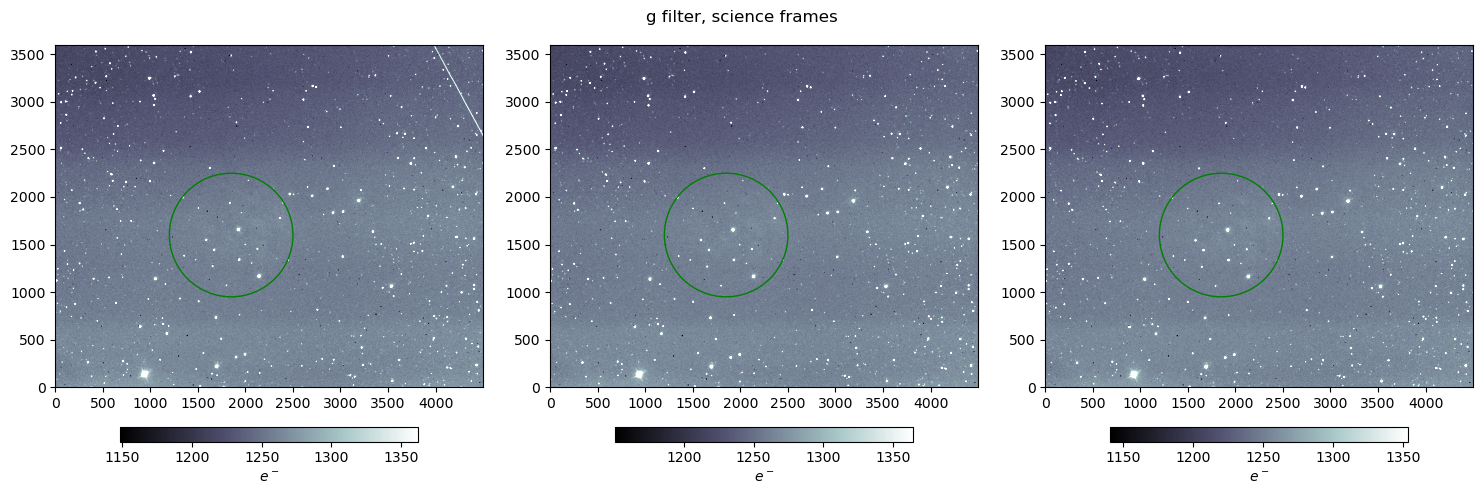

In [10]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("g filter, science frames")

for i in range(3):
    
    im = ax[i].imshow(frame_sky[i], clim=np.quantile(frame_sky[i], [0.01, 0.99]), cmap='bone', origin='lower')  
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  

from matplotlib.patches import Circle
radius = 650
center = (1850,1600)
for i in range(3):
    ax[i].add_patch(Circle(center, radius, color='green', fill=False))

plt.tight_layout()
plt.show()


**Sky subtraction**

Photutils.background: https://photutils.readthedocs.io/en/stable/api/photutils.background.Background2D.html#photutils.background.Background2D

- It first identifies the regions of the image that are not contaminated by sources (stars, galaxies, etc.), typically by using segmentation or thresholding techniques.
- It then estimates the background level in those regions, using a selected statistical method (mean, median, etc.).
- The background model is smoothed over the image, so you get a smooth map of the background which you can subtract from your original image.

MedianBackground: computes a median background in your image in a specified region. This is particularly useful when you have an image with significant outliers (e.g., bright stars or galaxies) that could skew the average value.

- It divides the image into small regions or blocks (sub-arrays).
- For each block, it computes the median pixel value and uses that as the estimate for the background in that region.

BkgZoomInterpolator: used to interpolate the background model computed from Background2D. Sometimes, the background estimate might not be smooth enough or could have regions with missing data. The BkgZoomInterpolator allows you to interpolate the background estimation in a finer grid to get a smooth and continuous background map that can be subtracted from the image.

- After computing the background using a method like median, the interpolation method will use zooming (resampling) techniques to generate a more refined background model across the image.
- It can be useful if you need a higher resolution or smoother background model for more accurate subtraction.

In [11]:
# sky subtraction

# Covers the nebula with a circular mask

Y, X = np.ogrid[:3599, :4499]
radius = 650
center = (1850,1600)
mask_circ = np.sqrt((X - center[0])**2 + (Y-center[1])**2) <= radius

from photutils.background import (Background2D, MedianBackground, BkgZoomInterpolator)  
from astropy import stats as astrostats

frame_sky_subtracted  = []

for i in range(3):

    box_size = (50,50) 
    filter_size = (3,3)
    exclude_percentile = 30
    
    bkg = Background2D(frame_sky[i],
                    mask=mask_circ,                             # 'mask' defines which pixels to exclude from the background estimation.
                    box_size=box_size,                          # 'box_size' is the size (in pixels) of the box used to estimate the background.
                    sigma_clip=astrostats.SigmaClip(sigma=3.),  # 'sigma_clip' is the method to use for robust averaging within the grid cells.
                    filter_size=filter_size,                    # 'filter_size' is how many cells to "averaged" before doing the interpolation. This can also be a rectangle -- e.g. (3,4) -- if desired.
                    exclude_percentile=exclude_percentile,      # 'exclude_percentile'. If a mesh has more than this percent of its pixels masked then it will be excluded from the low-resolution map.
                    bkg_estimator=MedianBackground(),           # 'bkg_estimator' is the method to use for averaging the values in the cells.
                    interpolator=BkgZoomInterpolator(order=3))  # 'interpolator' is the method to use to interpolate the background (bicubic spline in this case).

    frame_sky_subtracted .append(frame_sky[i] - bkg.background)

del frame_sky


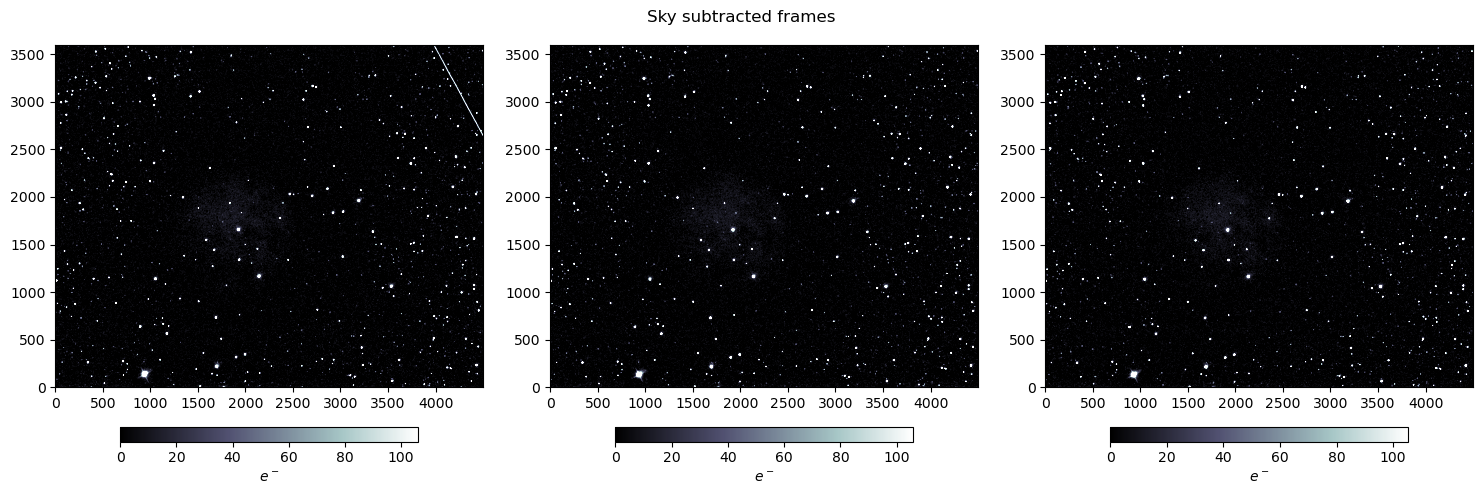

In [12]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
fig.suptitle("Sky subtracted frames")

for i in range(3):
    
    im = ax[i].imshow(frame_sky_subtracted[i], clim=[0,np.quantile(frame_sky_subtracted[i], [0.99])], cmap='bone', origin='lower') 
    plt.colorbar(im, ax=ax[i], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$") 

plt.tight_layout()
plt.show()


# Dithering

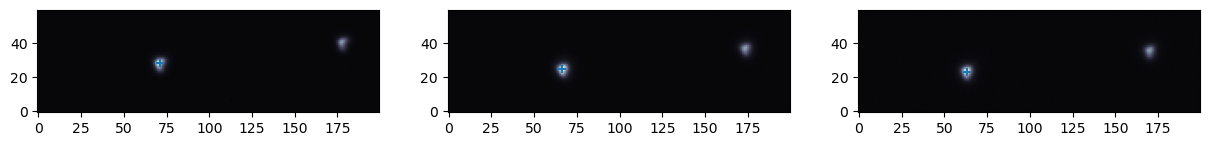

In [14]:
# define rectangle for photutils
# does NOT account for rotation

from photutils.centroids import centroid_quadratic

fig, ax = plt.subplots(1,3,figsize=(15, 5))

x_sx = 2850
x_dx = 3050
y_sx = 1800
y_dx = 1860

star_centroid = []

for i in range(3):
    
    rectangle = frame_sky_subtracted[i][y_sx:y_dx,x_sx:x_dx]
    
    star_centroid.append(centroid_quadratic(rectangle)) 
    im = ax[i].imshow(rectangle, cmap='bone', origin='lower',aspect='equal')  
    ax[i].scatter(star_centroid[i][0],star_centroid[i][1],marker='+')

In [15]:
print(star_centroid)
offsets = (star_centroid[0]-star_centroid).astype(int) # refered to first exposure 
print(offsets)

[array([71.0596902 , 28.09243482]), array([66.53285062, 24.60382166]), array([63.11650953, 23.23148416])]
[[0 0]
 [4 3]
 [7 4]]


In [16]:
frame_sky_subtracted_aligned = []

for i in range(3):
    frame_sky_subtracted_aligned.append(np.roll(frame_sky_subtracted[i], (offsets[i, 0], offsets[i, 1]), axis=(1, 0)))

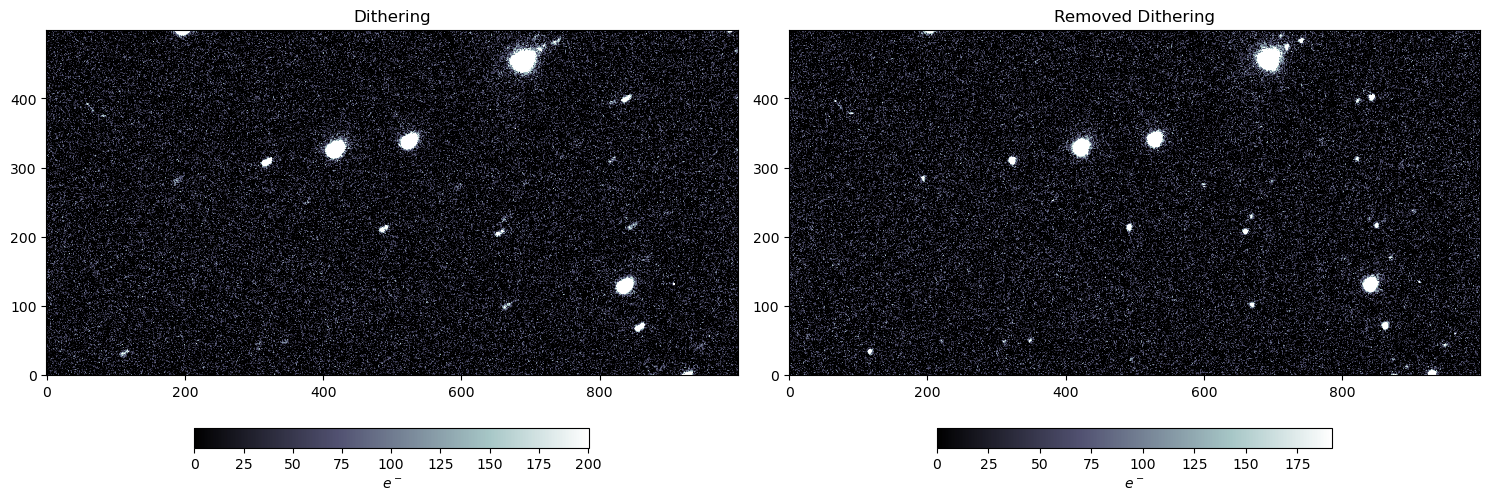

In [17]:
stacked_exposure_no_aligned = frame_sky_subtracted[0] + frame_sky_subtracted[1] + frame_sky_subtracted[2]
stacked_exposure_aligned = frame_sky_subtracted_aligned[0] + frame_sky_subtracted_aligned[1] + frame_sky_subtracted_aligned[2]


fig, ax = plt.subplots(1,2,figsize=(15,6))

im1 = ax[0].imshow(stacked_exposure_no_aligned[1500:2000,2500:3500], clim=[0,np.quantile(stacked_exposure_no_aligned, [0.99])], cmap='bone', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im1, ax=ax[0], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[0].set_title("Dithering")    

im2 = ax[1].imshow(stacked_exposure_aligned[1500:2000,2500:3500], clim=[0,np.quantile(stacked_exposure_aligned, [0.99])], cmap='bone', origin='lower')  # Use clim to scale the image based on the 1st and 99th quantiles
plt.colorbar(im2, ax=ax[1], location='bottom', fraction=0.0375, pad=0.1, label="$e^-$")  
ax[1].set_title("Removed Dithering")    

plt.tight_layout()
plt.show()

In [18]:
hdu = fits.PrimaryHDU(stacked_exposure_aligned)
hdu.writeto('data/cleaned_not_calibrated/g_filter_science.fit', overwrite=True)